In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperature
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperature
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperature
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (temperature) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (temperature) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (temperature) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (temperature) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 1
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)

#Since the NaN values of GHI are gone which is used in data preparation, simulate these in solar activity instead
df['solar_activity'].loc[df['Year'] > 2020] = np.nan
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when GHI is removed as a predictor
df_trimmed = df_trimmed.drop(['GHI'], axis=1)

n_vars = df_trimmed.shape[1]-1
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 22
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\


C:\Users\User\AppData\Local\Temp\ipykernel_443428\1675105325.py:399: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['solar_activity'].loc[df['Year'] > 2020] = np.nan


     file_id  temperatures      slp  wet_bulb_temperature  specific_humidity  \
0       6678         20.84  1016.20                 18.08              12.82   
1       6678         20.69  1017.48                 17.71              12.33   
2       6678         20.47  1018.26                 17.29              12.14   
3       6678         20.30  1018.41                 17.20              11.90   
4       6678         20.46  1017.92                 17.75              12.75   
..       ...           ...      ...                   ...                ...   
643     8000         13.02  1016.94                  7.64               5.15   
644     8000         13.47  1016.16                  7.88               5.24   
645     8000         11.84  1017.90                  7.13               5.36   
646     8000         12.86  1016.17                  7.66               5.43   
647     8000         13.58  1015.12                  8.11               5.32   

     water      WDSP  PRCP  SNDP  regio

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

1
22
(19, 243)
(2, 243)


[I 2025-06-07 07:17:17,077] A new study created in memory with name: no-name-789b889e-f599-43c4-bcb6-97ae34a1c0bf
[I 2025-06-07 07:18:42,905] Trial 0 finished with value: 0.08029798418283463 and parameters: {'lr': 0.005868960955201205, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4981476807681996}. Best is trial 0 with value: 0.08029798418283463.


Cross Validation Accuracies:
[0.039861902594566345, 0.03778471797704697, 0.0941973626613617, 0.11210270971059799, 0.11754322797060013]
Mean Cross Validation Accuracy:
0.08029798418283463
Standard Deviation of Cross Validation Accuracy:
0.03474016686918198


[I 2025-06-07 07:20:34,808] Trial 1 finished with value: 0.057611802220344545 and parameters: {'lr': 0.013741108200664607, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.35688010953661087}. Best is trial 1 with value: 0.057611802220344545.


Cross Validation Accuracies:
[0.052424270659685135, 0.10073260217905045, 0.034895531833171844, 0.044370975345373154, 0.05563563108444214]
Mean Cross Validation Accuracy:
0.057611802220344545
Standard Deviation of Cross Validation Accuracy:
0.02272253314120609


[I 2025-06-07 07:22:41,978] Trial 2 finished with value: 0.08572648763656616 and parameters: {'lr': 0.001694661112228294, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.10050015636226016}. Best is trial 1 with value: 0.057611802220344545.


Cross Validation Accuracies:
[0.07249025255441666, 0.13715164363384247, 0.06953424960374832, 0.11126969009637833, 0.03818660229444504]
Mean Cross Validation Accuracy:
0.08572648763656616
Standard Deviation of Cross Validation Accuracy:
0.03462493047285594


[I 2025-06-07 07:24:23,937] Trial 3 finished with value: 0.15959802269935608 and parameters: {'lr': 0.007541979437704763, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.4823027111118896}. Best is trial 1 with value: 0.057611802220344545.


Cross Validation Accuracies:
[0.06841415166854858, 0.2575572431087494, 0.15016184747219086, 0.1642218679189682, 0.15763500332832336]
Mean Cross Validation Accuracy:
0.15959802269935608
Standard Deviation of Cross Validation Accuracy:
0.06004128911334729


[I 2025-06-07 07:25:55,043] Trial 4 finished with value: 2.784341847896576 and parameters: {'lr': 0.1286049351327142, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.25473238407013155}. Best is trial 1 with value: 0.057611802220344545.


Cross Validation Accuracies:
[0.7866262793540955, 5.5848002433776855, 3.2361624240875244, 1.9764690399169922, 2.337651252746582]
Mean Cross Validation Accuracy:
2.784341847896576
Standard Deviation of Cross Validation Accuracy:
1.605600667186921


[I 2025-06-07 07:28:24,280] Trial 5 finished with value: 1.711832332611084 and parameters: {'lr': 0.2184871134626066, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.37419446987412264}. Best is trial 1 with value: 0.057611802220344545.


Cross Validation Accuracies:
[2.0018115043640137, 1.975711464881897, 1.4943115711212158, 1.4972145557403564, 1.590112566947937]
Mean Cross Validation Accuracy:
1.711832332611084
Standard Deviation of Cross Validation Accuracy:
0.2288719684363593


[I 2025-06-07 07:30:33,459] Trial 6 finished with value: 0.3044266700744629 and parameters: {'lr': 0.06438807974639721, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3199363305546409}. Best is trial 1 with value: 0.057611802220344545.


Cross Validation Accuracies:
[0.27459385991096497, 0.3580276072025299, 0.30679965019226074, 0.26088908314704895, 0.3218231499195099]
Mean Cross Validation Accuracy:
0.3044266700744629
Standard Deviation of Cross Validation Accuracy:
0.03454517924214322


[I 2025-06-07 07:34:41,374] Trial 7 finished with value: 34.85064125061035 and parameters: {'lr': 0.33581567487691893, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.27956956071941286}. Best is trial 1 with value: 0.057611802220344545.


Cross Validation Accuracies:
[21.794832229614258, 35.47386169433594, 41.28400421142578, 41.28559494018555, 34.414913177490234]
Mean Cross Validation Accuracy:
34.85064125061035
Standard Deviation of Cross Validation Accuracy:
7.125015085464377


[I 2025-06-07 07:39:53,638] Trial 8 finished with value: 0.8368567824363708 and parameters: {'lr': 0.12695081867534624, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2629054207539707}. Best is trial 1 with value: 0.057611802220344545.


Cross Validation Accuracies:
[1.7788642644882202, 0.6504810452461243, 0.65478515625, 0.585335373878479, 0.5148180723190308]
Mean Cross Validation Accuracy:
0.8368567824363708
Standard Deviation of Cross Validation Accuracy:
0.47375859643789237


[I 2025-06-07 07:45:02,769] Trial 9 finished with value: 0.11563214510679246 and parameters: {'lr': 0.005277065670335184, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.27545780990352386}. Best is trial 1 with value: 0.057611802220344545.


Cross Validation Accuracies:
[0.06080256402492523, 0.09355420619249344, 0.13012894988059998, 0.16186586022377014, 0.13180914521217346]
Mean Cross Validation Accuracy:
0.11563214510679246
Standard Deviation of Cross Validation Accuracy:
0.03493745108874947


[I 2025-06-07 07:49:56,968] Trial 10 finished with value: 0.06146282069385052 and parameters: {'lr': 0.8233125216915332, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.4020371767970031}. Best is trial 1 with value: 0.057611802220344545.


Cross Validation Accuracies:
[0.08076559752225876, 0.11540892720222473, 0.017767956480383873, 0.03830724209547043, 0.055064380168914795]
Mean Cross Validation Accuracy:
0.06146282069385052
Standard Deviation of Cross Validation Accuracy:
0.0339680485771861


[I 2025-06-07 07:55:27,266] Trial 11 finished with value: 0.061756755039095876 and parameters: {'lr': 0.9900118739328254, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.40593680383239095}. Best is trial 1 with value: 0.057611802220344545.


Cross Validation Accuracies:
[0.08420207351446152, 0.10909207910299301, 0.022504283115267754, 0.038471367210149765, 0.054513972252607346]
Mean Cross Validation Accuracy:
0.061756755039095876
Standard Deviation of Cross Validation Accuracy:
0.031240515253952997


[I 2025-06-07 08:01:06,976] Trial 12 finished with value: 0.0634455218911171 and parameters: {'lr': 0.034432466060610366, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.40089331973269243}. Best is trial 1 with value: 0.057611802220344545.


Cross Validation Accuracies:
[0.0877605527639389, 0.11607881635427475, 0.020847998559474945, 0.03842043876647949, 0.05411980301141739]
Mean Cross Validation Accuracy:
0.0634455218911171
Standard Deviation of Cross Validation Accuracy:
0.034319840397064046


[I 2025-06-07 08:06:59,179] Trial 13 finished with value: 0.058188793063163755 and parameters: {'lr': 0.01675714770696114, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3533062915474058}. Best is trial 1 with value: 0.057611802220344545.


Cross Validation Accuracies:
[0.06144755706191063, 0.10938282310962677, 0.028852257877588272, 0.03864332288503647, 0.05261800438165665]
Mean Cross Validation Accuracy:
0.058188793063163755
Standard Deviation of Cross Validation Accuracy:
0.02794687690211651


[I 2025-06-07 08:12:00,238] Trial 14 finished with value: 0.06399356573820114 and parameters: {'lr': 0.013982720296133748, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.18480936011793972}. Best is trial 1 with value: 0.057611802220344545.


Cross Validation Accuracies:
[0.08444917947053909, 0.12115561217069626, 0.018859583884477615, 0.038337379693984985, 0.057166073471307755]
Mean Cross Validation Accuracy:
0.06399356573820114
Standard Deviation of Cross Validation Accuracy:
0.03585488121993854


[I 2025-06-07 08:16:49,784] Trial 15 finished with value: 0.06223504990339279 and parameters: {'lr': 0.020422320559080394, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3551643256923122}. Best is trial 1 with value: 0.057611802220344545.


Cross Validation Accuracies:
[0.0750611275434494, 0.10792505741119385, 0.0345488116145134, 0.03990188241004944, 0.053738370537757874]
Mean Cross Validation Accuracy:
0.06223504990339279
Standard Deviation of Cross Validation Accuracy:
0.02679394250500819


[I 2025-06-07 08:21:32,190] Trial 16 finished with value: 0.06285585165023803 and parameters: {'lr': 0.0015758294187267034, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.44383754735007397}. Best is trial 1 with value: 0.057611802220344545.


Cross Validation Accuracies:
[0.04507850110530853, 0.10166864097118378, 0.045048296451568604, 0.07219188660383224, 0.05029193311929703]
Mean Cross Validation Accuracy:
0.06285585165023803
Standard Deviation of Cross Validation Accuracy:
0.021838449701981778


[I 2025-06-07 08:25:39,441] Trial 17 finished with value: 0.3040913790464401 and parameters: {'lr': 0.04087580521055688, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.32819477163025734}. Best is trial 1 with value: 0.057611802220344545.


Cross Validation Accuracies:
[0.6156567335128784, 0.20191580057144165, 0.13743452727794647, 0.28533628582954407, 0.28011354804039]
Mean Cross Validation Accuracy:
0.3040913790464401
Standard Deviation of Cross Validation Accuracy:
0.16505393971863425


[I 2025-06-07 08:31:24,182] Trial 18 finished with value: 0.06029340922832489 and parameters: {'lr': 0.014443238366205, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.22799620788813899}. Best is trial 1 with value: 0.057611802220344545.


Cross Validation Accuracies:
[0.0928429663181305, 0.03974460810422897, 0.0776471421122551, 0.03847331181168556, 0.052759017795324326]
Mean Cross Validation Accuracy:
0.06029340922832489
Standard Deviation of Cross Validation Accuracy:
0.021520978811031172


[I 2025-06-07 08:36:30,385] Trial 19 finished with value: 0.06286366544663906 and parameters: {'lr': 0.0038309137442099545, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.18028613868744237}. Best is trial 1 with value: 0.057611802220344545.


Cross Validation Accuracies:
[0.08194022625684738, 0.12074393779039383, 0.017360219731926918, 0.03938871622085571, 0.05488522723317146]
Mean Cross Validation Accuracy:
0.06286366544663906
Standard Deviation of Cross Validation Accuracy:
0.03577522435519805


[I 2025-06-07 08:41:39,419] Trial 20 finished with value: 0.06162859573960304 and parameters: {'lr': 0.002437797729597702, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.44496532833022284}. Best is trial 1 with value: 0.057611802220344545.


Cross Validation Accuracies:
[0.03915666416287422, 0.1189495399594307, 0.042523615062236786, 0.047311726957559586, 0.060201432555913925]
Mean Cross Validation Accuracy:
0.06162859573960304
Standard Deviation of Cross Validation Accuracy:
0.029538748003933548


[I 2025-06-07 08:48:02,546] Trial 21 finished with value: 0.16540080159902573 and parameters: {'lr': 0.012973100154100801, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.22600614518413956}. Best is trial 1 with value: 0.057611802220344545.


Cross Validation Accuracies:
[0.432114839553833, 0.1324676275253296, 0.0361299067735672, 0.08209813386201859, 0.14419350028038025]
Mean Cross Validation Accuracy:
0.16540080159902573
Standard Deviation of Cross Validation Accuracy:
0.1387955477146321


[I 2025-06-07 08:53:31,922] Trial 22 finished with value: 0.0894866943359375 and parameters: {'lr': 0.010926968331826045, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3511249238920899}. Best is trial 1 with value: 0.057611802220344545.


Cross Validation Accuracies:
[0.04554407671093941, 0.03794189915060997, 0.020137473940849304, 0.20946292579174042, 0.1343470960855484]
Mean Cross Validation Accuracy:
0.0894866943359375
Standard Deviation of Cross Validation Accuracy:
0.07183854909909242


[I 2025-06-07 08:59:15,203] Trial 23 finished with value: 0.06014200821518898 and parameters: {'lr': 0.024108653149093575, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.21670472461118803}. Best is trial 1 with value: 0.057611802220344545.


Cross Validation Accuracies:
[0.09377138316631317, 0.0748305544257164, 0.018372055143117905, 0.04001474380493164, 0.07372130453586578]
Mean Cross Validation Accuracy:
0.06014200821518898
Standard Deviation of Cross Validation Accuracy:
0.027132715640828423


[I 2025-06-07 09:05:58,311] Trial 24 finished with value: 0.13290934935212134 and parameters: {'lr': 0.06814214713618792, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.14004151839109086}. Best is trial 1 with value: 0.057611802220344545.


Cross Validation Accuracies:
[0.11352203786373138, 0.20240570604801178, 0.14992375671863556, 0.14317835867404938, 0.055516887456178665]
Mean Cross Validation Accuracy:
0.13290934935212134
Standard Deviation of Cross Validation Accuracy:
0.04814591822689182


[I 2025-06-07 09:12:35,639] Trial 25 finished with value: 0.10011781230568886 and parameters: {'lr': 0.028327050781808537, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.307133564564352}. Best is trial 1 with value: 0.057611802220344545.


Cross Validation Accuracies:
[0.10944152623414993, 0.15520426630973816, 0.023344237357378006, 0.15991950035095215, 0.052679531276226044]
Mean Cross Validation Accuracy:
0.10011781230568886
Standard Deviation of Cross Validation Accuracy:
0.05448350808565322


[I 2025-06-07 09:17:52,912] Trial 26 finished with value: 0.06337946504354477 and parameters: {'lr': 0.05049513575327833, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.19754100138164496}. Best is trial 1 with value: 0.057611802220344545.


Cross Validation Accuracies:
[0.09621959924697876, 0.10892829298973083, 0.0186738483607769, 0.03828937187790871, 0.054786212742328644]
Mean Cross Validation Accuracy:
0.06337946504354477
Standard Deviation of Cross Validation Accuracy:
0.034220225203613265


[I 2025-06-07 09:24:21,556] Trial 27 finished with value: 0.05534060113132 and parameters: {'lr': 0.023641266757660522, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.34323488200343005}. Best is trial 27 with value: 0.05534060113132.


Cross Validation Accuracies:
[0.06683861464262009, 0.10093387961387634, 0.017832355573773384, 0.038361627608537674, 0.05273652821779251]
Mean Cross Validation Accuracy:
0.05534060113132
Standard Deviation of Cross Validation Accuracy:
0.027974583392520794


[I 2025-06-07 09:29:25,360] Trial 28 finished with value: 0.06046048663556576 and parameters: {'lr': 0.0034277962741033085, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.372057846056338}. Best is trial 27 with value: 0.05534060113132.


Cross Validation Accuracies:
[0.06744176894426346, 0.1208692193031311, 0.019842153415083885, 0.03822720795869827, 0.05592208355665207]
Mean Cross Validation Accuracy:
0.06046048663556576
Standard Deviation of Cross Validation Accuracy:
0.03424242416072541


[I 2025-06-07 09:34:56,950] Trial 29 finished with value: 0.06469036005437374 and parameters: {'lr': 0.00917770079265835, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.33928891229565206}. Best is trial 27 with value: 0.05534060113132.


Cross Validation Accuracies:
[0.08225395530462265, 0.1245456412434578, 0.01904013194143772, 0.037453897297382355, 0.060158174484968185]
Mean Cross Validation Accuracy:
0.06469036005437374
Standard Deviation of Cross Validation Accuracy:
0.03670815577130098


[I 2025-06-07 09:40:20,851] Trial 30 finished with value: 0.06065358445048332 and parameters: {'lr': 0.005701841173103974, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.43328683274595753}. Best is trial 27 with value: 0.05534060113132.


Cross Validation Accuracies:
[0.07825550436973572, 0.11107005923986435, 0.0184694305062294, 0.040462542325258255, 0.05501038581132889]
Mean Cross Validation Accuracy:
0.06065358445048332
Standard Deviation of Cross Validation Accuracy:
0.03184548706491439


[I 2025-06-07 09:46:22,099] Trial 31 finished with value: 0.06374501660466195 and parameters: {'lr': 0.018967519132961495, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3048385758348096}. Best is trial 27 with value: 0.05534060113132.


Cross Validation Accuracies:
[0.06673160940408707, 0.10709068179130554, 0.036444272845983505, 0.03824632614850998, 0.07021219283342361]
Mean Cross Validation Accuracy:
0.06374501660466195
Standard Deviation of Cross Validation Accuracy:
0.025787999612811068


[I 2025-06-07 09:52:31,486] Trial 32 finished with value: 0.07321718633174897 and parameters: {'lr': 0.0216728517490755, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.38022759310714377}. Best is trial 27 with value: 0.05534060113132.


Cross Validation Accuracies:
[0.10278349369764328, 0.11336863040924072, 0.02878449112176895, 0.06575953215360641, 0.05538978427648544]
Mean Cross Validation Accuracy:
0.07321718633174897
Standard Deviation of Cross Validation Accuracy:
0.031093414950005883


[I 2025-06-07 09:57:58,792] Trial 33 finished with value: 0.06137637160718441 and parameters: {'lr': 0.02591877980679412, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.10285364583465349}. Best is trial 27 with value: 0.05534060113132.


Cross Validation Accuracies:
[0.07734449952840805, 0.11549091339111328, 0.01886768452823162, 0.0389631949365139, 0.0562155656516552]
Mean Cross Validation Accuracy:
0.06137637160718441
Standard Deviation of Cross Validation Accuracy:
0.03322450187903737


[I 2025-06-07 10:03:43,151] Trial 34 finished with value: 0.06154820695519447 and parameters: {'lr': 0.008468381863219443, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4851492078597865}. Best is trial 27 with value: 0.05534060113132.


Cross Validation Accuracies:
[0.05510561540722847, 0.1293596774339676, 0.02433931827545166, 0.04580460116267204, 0.0531318224966526]
Mean Cross Validation Accuracy:
0.06154820695519447
Standard Deviation of Cross Validation Accuracy:
0.03561769381033327


[I 2025-06-07 10:09:53,061] Trial 35 finished with value: 0.13433690667152404 and parameters: {'lr': 0.08857845640761217, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2927577883156186}. Best is trial 27 with value: 0.05534060113132.


Cross Validation Accuracies:
[0.2716112732887268, 0.17821161448955536, 0.07565148174762726, 0.07486821711063385, 0.07134194672107697]
Mean Cross Validation Accuracy:
0.13433690667152404
Standard Deviation of Cross Validation Accuracy:
0.07964685911198018


[I 2025-06-07 10:16:08,273] Trial 36 finished with value: 0.18425939977169037 and parameters: {'lr': 0.04684355574984961, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.22976867648250557}. Best is trial 27 with value: 0.05534060113132.


Cross Validation Accuracies:
[0.08128005266189575, 0.372886061668396, 0.14887788891792297, 0.18392515182495117, 0.13432784378528595]
Mean Cross Validation Accuracy:
0.18425939977169037
Standard Deviation of Cross Validation Accuracy:
0.09992986222812704


[I 2025-06-07 10:21:31,598] Trial 37 finished with value: 0.06596151925623417 and parameters: {'lr': 0.0010692290634388474, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.3290875134101424}. Best is trial 27 with value: 0.05534060113132.


Cross Validation Accuracies:
[0.028829144313931465, 0.09837513417005539, 0.07275781035423279, 0.08734168112277985, 0.042503826320171356]
Mean Cross Validation Accuracy:
0.06596151925623417
Standard Deviation of Cross Validation Accuracy:
0.026393256535138986


[I 2025-06-07 10:28:07,904] Trial 38 finished with value: 0.5425911188125611 and parameters: {'lr': 0.0076924199786186824, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3613096433073239}. Best is trial 27 with value: 0.05534060113132.


Cross Validation Accuracies:
[0.5792708396911621, 0.6389120221138, 0.502190351486206, 0.48928678035736084, 0.5032956004142761]
Mean Cross Validation Accuracy:
0.5425911188125611
Standard Deviation of Cross Validation Accuracy:
0.05769026018556941


[I 2025-06-07 10:33:17,407] Trial 39 finished with value: 0.19234091341495513 and parameters: {'lr': 0.11241996956792367, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.2625440499203312}. Best is trial 27 with value: 0.05534060113132.


Cross Validation Accuracies:
[0.24545074999332428, 0.12052758038043976, 0.21818731725215912, 0.1651008278131485, 0.21243809163570404]
Mean Cross Validation Accuracy:
0.19234091341495513
Standard Deviation of Cross Validation Accuracy:
0.04425328229691765


[I 2025-06-07 10:38:01,581] Trial 40 finished with value: 0.06444277614355087 and parameters: {'lr': 0.017131204031253334, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3876643288728393}. Best is trial 27 with value: 0.05534060113132.


Cross Validation Accuracies:
[0.08085241168737411, 0.11185836791992188, 0.017868872731924057, 0.053861141204833984, 0.05777308717370033]
Mean Cross Validation Accuracy:
0.06444277614355087
Standard Deviation of Cross Validation Accuracy:
0.031122656410116835


[I 2025-06-07 10:44:03,011] Trial 41 finished with value: 0.05121580883860588 and parameters: {'lr': 0.013560643010393014, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2254480234008693}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.07446160167455673, 0.05532872676849365, 0.03474768251180649, 0.03882627934217453, 0.052714753895998]
Mean Cross Validation Accuracy:
0.05121580883860588
Standard Deviation of Cross Validation Accuracy:
0.01403017776518446


[I 2025-06-07 10:49:57,665] Trial 42 finished with value: 0.0804412379860878 and parameters: {'lr': 0.03017022543241672, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.24786834039102207}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.07640434801578522, 0.03884422406554222, 0.043123695999383926, 0.16715176403522491, 0.07668215781450272]
Mean Cross Validation Accuracy:
0.0804412379860878
Standard Deviation of Cross Validation Accuracy:
0.04619968181518632


[I 2025-06-07 10:55:49,779] Trial 43 finished with value: 0.09767584800720215 and parameters: {'lr': 0.010638226738940656, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.28476128407171153}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.1826348900794983, 0.0414823517203331, 0.07528562098741531, 0.09107378125190735, 0.09790259599685669]
Mean Cross Validation Accuracy:
0.09767584800720215
Standard Deviation of Cross Validation Accuracy:
0.04673480249423191


[I 2025-06-07 11:01:31,976] Trial 44 finished with value: 0.19396745264530182 and parameters: {'lr': 0.18893251290429364, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.205994335895235}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.24753506481647491, 0.24973616003990173, 0.21782127022743225, 0.13206852972507477, 0.12267623841762543]
Mean Cross Validation Accuracy:
0.19396745264530182
Standard Deviation of Cross Validation Accuracy:
0.05561035208694138


[I 2025-06-07 11:07:32,683] Trial 45 finished with value: 0.08662499189376831 and parameters: {'lr': 0.0058017107341565176, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3082305224180086}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.02800999954342842, 0.13578639924526215, 0.10295863449573517, 0.10756038129329681, 0.058809544891119]
Mean Cross Validation Accuracy:
0.08662499189376831
Standard Deviation of Cross Validation Accuracy:
0.038291875908411134


[I 2025-06-07 11:12:46,742] Trial 46 finished with value: 0.06217731721699238 and parameters: {'lr': 0.06233946179523469, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.14858604672649506}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.0925220176577568, 0.10627689212560654, 0.01780925877392292, 0.03995143622159958, 0.05432698130607605]
Mean Cross Validation Accuracy:
0.06217731721699238
Standard Deviation of Cross Validation Accuracy:
0.03283204386541725


[I 2025-06-07 11:17:48,513] Trial 47 finished with value: 1.3260741353034973 and parameters: {'lr': 0.03670415120918292, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.24424195553206351}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[1.4254462718963623, 1.0374387502670288, 0.7849264740943909, 1.7481871843338013, 1.6343719959259033]
Mean Cross Validation Accuracy:
1.3260741353034973
Standard Deviation of Cross Validation Accuracy:
0.3631123780000565


[I 2025-06-07 11:23:19,468] Trial 48 finished with value: 0.05961322262883186 and parameters: {'lr': 0.024169023732104843, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.34477643276859954}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.07447033375501633, 0.07539300620555878, 0.04390830919146538, 0.05165578052401543, 0.05263868346810341]
Mean Cross Validation Accuracy:
0.05961322262883186
Standard Deviation of Cross Validation Accuracy:
0.012871244758572103


[I 2025-06-07 11:27:56,307] Trial 49 finished with value: 0.25539467558264733 and parameters: {'lr': 0.014939758799084797, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.42068908021108464}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.25931301712989807, 0.03877490386366844, 0.6375580430030823, 0.14230024814605713, 0.1990271657705307]
Mean Cross Validation Accuracy:
0.25539467558264733
Standard Deviation of Cross Validation Accuracy:
0.20442894314544555


[I 2025-06-07 11:33:17,871] Trial 50 finished with value: 0.06942440085113048 and parameters: {'lr': 0.00725673607536907, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3504292058425889}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.09037435054779053, 0.1455289125442505, 0.01994103007018566, 0.03828166425228119, 0.05299604684114456]
Mean Cross Validation Accuracy:
0.06942440085113048
Standard Deviation of Cross Validation Accuracy:
0.04454023335037215


[I 2025-06-07 11:38:49,922] Trial 51 finished with value: 0.07494107857346535 and parameters: {'lr': 0.022118696705132453, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.32491048029943864}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.06664363294839859, 0.16980069875717163, 0.04374132677912712, 0.04169708490371704, 0.052822649478912354]
Mean Cross Validation Accuracy:
0.07494107857346535
Standard Deviation of Cross Validation Accuracy:
0.04823900429745893


[I 2025-06-07 11:44:00,909] Trial 52 finished with value: 0.07090481370687485 and parameters: {'lr': 0.025025145841854897, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.39107206744067236}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.037348441779613495, 0.18539460003376007, 0.03834547474980354, 0.03825856372714043, 0.0551769882440567]
Mean Cross Validation Accuracy:
0.07090481370687485
Standard Deviation of Cross Validation Accuracy:
0.05763192510223161


[I 2025-06-07 11:50:25,137] Trial 53 finished with value: 0.10218080878257751 and parameters: {'lr': 0.012670473970094909, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3388570167604669}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.10626044869422913, 0.12426353991031647, 0.01944131776690483, 0.039641354233026505, 0.22129738330841064]
Mean Cross Validation Accuracy:
0.10218080878257751
Standard Deviation of Cross Validation Accuracy:
0.07134431379097432


[I 2025-06-07 11:56:19,149] Trial 54 finished with value: 0.05800482295453548 and parameters: {'lr': 0.03297397851117708, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3683487067572826}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.07596305757761002, 0.1012704148888588, 0.018621811643242836, 0.0395340733230114, 0.054634757339954376]
Mean Cross Validation Accuracy:
0.05800482295453548
Standard Deviation of Cross Validation Accuracy:
0.028628507297263017


[I 2025-06-07 12:01:16,900] Trial 55 finished with value: 0.061987444385886194 and parameters: {'lr': 0.034174701603886005, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.3669410696723525}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.08128223568201065, 0.11694411933422089, 0.01783389411866665, 0.03964537754654884, 0.05423159524798393]
Mean Cross Validation Accuracy:
0.061987444385886194
Standard Deviation of Cross Validation Accuracy:
0.03435515169589888


[I 2025-06-07 12:05:46,068] Trial 56 finished with value: 0.06326252743601798 and parameters: {'lr': 0.004452035166680767, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.41417466494031846}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.08352149277925491, 0.10596480220556259, 0.04291137307882309, 0.041069380939006805, 0.04284558817744255]
Mean Cross Validation Accuracy:
0.06326252743601798
Standard Deviation of Cross Validation Accuracy:
0.026673832087154976


[I 2025-06-07 12:10:59,095] Trial 57 finished with value: 0.07017005383968353 and parameters: {'lr': 0.017936148527999678, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3423444218086946}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.07631023228168488, 0.13280002772808075, 0.05053995922207832, 0.03826892375946045, 0.052931126207113266]
Mean Cross Validation Accuracy:
0.07017005383968353
Standard Deviation of Cross Validation Accuracy:
0.03364645229908609


[I 2025-06-07 12:15:41,438] Trial 58 finished with value: 0.10620489493012428 and parameters: {'lr': 0.057230541721595564, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.31378792491966523}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.08119704574346542, 0.11491738259792328, 0.23945032060146332, 0.040850717574357986, 0.05460900813341141]
Mean Cross Validation Accuracy:
0.10620489493012428
Standard Deviation of Cross Validation Accuracy:
0.07125860994550585


[I 2025-06-07 12:21:10,261] Trial 59 finished with value: 0.46699545681476595 and parameters: {'lr': 0.04084766104674914, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.46149665446535737}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.06466542184352875, 0.3632386028766632, 1.3160291910171509, 0.3034370243549347, 0.2876070439815521]
Mean Cross Validation Accuracy:
0.46699545681476595
Standard Deviation of Cross Validation Accuracy:
0.4364458241478025


[I 2025-06-07 12:25:45,814] Trial 60 finished with value: 0.0647328995168209 and parameters: {'lr': 0.011319891366451484, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.274650002690891}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.08603296428918839, 0.12111151218414307, 0.01978408545255661, 0.03859042748808861, 0.05814550817012787]
Mean Cross Validation Accuracy:
0.0647328995168209
Standard Deviation of Cross Validation Accuracy:
0.035719628161307415


[I 2025-06-07 12:31:30,345] Trial 61 finished with value: 0.07318285889923573 and parameters: {'lr': 0.01614833107125723, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.36383261733152694}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.06523426622152328, 0.12829332053661346, 0.02589801512658596, 0.042503271251916885, 0.10398542135953903]
Mean Cross Validation Accuracy:
0.07318285889923573
Standard Deviation of Cross Validation Accuracy:
0.03801640306598026


[I 2025-06-07 12:37:05,794] Trial 62 finished with value: 0.07929828986525536 and parameters: {'lr': 0.5075085407718722, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1678078274573345}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.07775168120861053, 0.20637431740760803, 0.01776988059282303, 0.03826232627034187, 0.05633324384689331]
Mean Cross Validation Accuracy:
0.07929828986525536
Standard Deviation of Cross Validation Accuracy:
0.0665549360583662


[I 2025-06-07 12:42:50,190] Trial 63 finished with value: 0.08237133771181107 and parameters: {'lr': 0.07874562957261169, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3820146215957066}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.0445830412209034, 0.15406131744384766, 0.0449359156191349, 0.09177068620920181, 0.07650572806596756]
Mean Cross Validation Accuracy:
0.08237133771181107
Standard Deviation of Cross Validation Accuracy:
0.04022827985786666


[I 2025-06-07 12:48:19,521] Trial 64 finished with value: 0.0727656926959753 and parameters: {'lr': 0.024417909658264424, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2102858698127912}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.09065628796815872, 0.14009582996368408, 0.023361453786492348, 0.056072596460580826, 0.05364229530096054]
Mean Cross Validation Accuracy:
0.0727656926959753
Standard Deviation of Cross Validation Accuracy:
0.039846112472256674


[I 2025-06-07 12:54:18,867] Trial 65 finished with value: 0.05472114346921444 and parameters: {'lr': 0.031228691076623006, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.29305236840916543}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.07016497105360031, 0.08968360722064972, 0.020654695108532906, 0.03863222897052765, 0.05447021499276161]
Mean Cross Validation Accuracy:
0.05472114346921444
Standard Deviation of Cross Validation Accuracy:
0.02400135296513092


[I 2025-06-07 13:00:24,415] Trial 66 finished with value: 0.06299987211823463 and parameters: {'lr': 0.050826321763469136, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.398516280926234}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.06336405873298645, 0.11505457758903503, 0.0439249612390995, 0.03853095322847366, 0.05412480980157852]
Mean Cross Validation Accuracy:
0.06299987211823463
Standard Deviation of Cross Validation Accuracy:
0.027390406865716033


[I 2025-06-07 13:05:05,380] Trial 67 finished with value: 0.16977528780698775 and parameters: {'lr': 0.031986262244130544, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.29763510235151536}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.14799946546554565, 0.38391783833503723, 0.10421975702047348, 0.10559985786676407, 0.10713952034711838]
Mean Cross Validation Accuracy:
0.16977528780698775
Standard Deviation of Cross Validation Accuracy:
0.10832402427467813


[I 2025-06-07 13:10:26,477] Trial 68 finished with value: 0.06963585130870342 and parameters: {'lr': 0.009661332649781463, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.32211929180134075}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.08543062955141068, 0.1227385625243187, 0.028278866782784462, 0.04650012031197548, 0.0652310773730278]
Mean Cross Validation Accuracy:
0.06963585130870342
Standard Deviation of Cross Validation Accuracy:
0.03266324297873619


[I 2025-06-07 13:15:15,705] Trial 69 finished with value: 0.06578224971890449 and parameters: {'lr': 0.020147505644355062, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3523567274133787}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.06769631057977676, 0.10623745620250702, 0.05650272220373154, 0.045270275324583054, 0.0532044842839241]
Mean Cross Validation Accuracy:
0.06578224971890449
Standard Deviation of Cross Validation Accuracy:
0.021472485968818688


[I 2025-06-07 13:20:47,482] Trial 70 finished with value: 0.05537837594747543 and parameters: {'lr': 0.01336396670449305, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3338398751176982}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.03422518074512482, 0.12155970185995102, 0.02463151514530182, 0.03843652456998825, 0.05803895741701126]
Mean Cross Validation Accuracy:
0.05537837594747543
Standard Deviation of Cross Validation Accuracy:
0.03483360457329446


[I 2025-06-07 13:26:22,267] Trial 71 finished with value: 0.06526009365916252 and parameters: {'lr': 0.012359363287034962, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.33904406931417896}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.08059962093830109, 0.11015798896551132, 0.04313080385327339, 0.038251474499702454, 0.05416058003902435]
Mean Cross Validation Accuracy:
0.06526009365916252
Standard Deviation of Cross Validation Accuracy:
0.026808551915031547


[I 2025-06-07 13:32:01,566] Trial 72 finished with value: 0.06337030343711376 and parameters: {'lr': 0.015036778258286157, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.37353160751287084}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.07674545049667358, 0.11668943613767624, 0.01823149435222149, 0.05164778605103493, 0.05353735014796257]
Mean Cross Validation Accuracy:
0.06337030343711376
Standard Deviation of Cross Validation Accuracy:
0.032537488964764764


[I 2025-06-07 13:37:54,561] Trial 73 finished with value: 0.067536810785532 and parameters: {'lr': 0.007131385951700844, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3298111280019869}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.0923914909362793, 0.13252681493759155, 0.018018271774053574, 0.042118046432733536, 0.05262942984700203]
Mean Cross Validation Accuracy:
0.067536810785532
Standard Deviation of Cross Validation Accuracy:
0.040402685699298564


[I 2025-06-07 13:43:32,993] Trial 74 finished with value: 0.05346536785364151 and parameters: {'lr': 0.02834573079706415, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3583240608489019}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.070839062333107, 0.07478172332048416, 0.023321323096752167, 0.03940463438630104, 0.05898009613156319]
Mean Cross Validation Accuracy:
0.05346536785364151
Standard Deviation of Cross Validation Accuracy:
0.019457708797177776


[I 2025-06-07 13:49:12,567] Trial 75 finished with value: 0.08291444554924965 and parameters: {'lr': 0.02846441138387085, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3561850888962187}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.14888444542884827, 0.11244336515665054, 0.054873086512088776, 0.04431205242872238, 0.05405927821993828]
Mean Cross Validation Accuracy:
0.08291444554924965
Standard Deviation of Cross Validation Accuracy:
0.04082421151762723


[I 2025-06-07 13:55:00,749] Trial 76 finished with value: 0.44458017945289613 and parameters: {'lr': 0.0461944404914938, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3149119875366521}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.35931527614593506, 0.19192330539226532, 0.3455522954463959, 1.166951298713684, 0.15915872156620026]
Mean Cross Validation Accuracy:
0.44458017945289613
Standard Deviation of Cross Validation Accuracy:
0.3699182515424429


[I 2025-06-07 13:59:51,132] Trial 77 finished with value: 0.06401423774659634 and parameters: {'lr': 0.01801639963868275, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2856038129242233}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.08483688533306122, 0.12075157463550568, 0.019054079428315163, 0.037764545530080795, 0.05766410380601883]
Mean Cross Validation Accuracy:
0.06401423774659634
Standard Deviation of Cross Validation Accuracy:
0.035786853531110226


[I 2025-06-07 14:05:13,898] Trial 78 finished with value: 0.0682169258594513 and parameters: {'lr': 0.03985468220672429, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.37225910220316133}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.08177217841148376, 0.11988236010074615, 0.04255311191082001, 0.04110664874315262, 0.055770330131053925]
Mean Cross Validation Accuracy:
0.0682169258594513
Standard Deviation of Cross Validation Accuracy:
0.029670113528699468


[I 2025-06-07 14:10:38,990] Trial 79 finished with value: 0.06267670281231404 and parameters: {'lr': 0.013827764995721801, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.39519358538838095}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.07534444332122803, 0.06694066524505615, 0.01776563934981823, 0.09807104617357254, 0.05526171997189522]
Mean Cross Validation Accuracy:
0.06267670281231404
Standard Deviation of Cross Validation Accuracy:
0.026470353828612538


[I 2025-06-07 14:15:21,523] Trial 80 finished with value: 0.05952451229095459 and parameters: {'lr': 0.031087985894604774, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.410102244660264}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.07282163202762604, 0.11272266507148743, 0.019438818097114563, 0.03865901008248329, 0.05398043617606163]
Mean Cross Validation Accuracy:
0.05952451229095459
Standard Deviation of Cross Validation Accuracy:
0.031874208049561946


[I 2025-06-07 14:20:28,111] Trial 81 finished with value: 0.06158598251640797 and parameters: {'lr': 0.031111762104833556, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.4159112021724657}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.08072127401828766, 0.11274901032447815, 0.02162362076342106, 0.03845705837011337, 0.054378949105739594]
Mean Cross Validation Accuracy:
0.06158598251640797
Standard Deviation of Cross Validation Accuracy:
0.03214869706527903


[I 2025-06-07 14:25:33,976] Trial 82 finished with value: 0.06575261913239956 and parameters: {'lr': 0.01884630975995194, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.43691216922521126}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.07570355385541916, 0.12665273249149323, 0.01808592863380909, 0.04028753563761711, 0.06803334504365921]
Mean Cross Validation Accuracy:
0.06575261913239956
Standard Deviation of Cross Validation Accuracy:
0.036697766908026445


[I 2025-06-07 14:30:28,169] Trial 83 finished with value: 0.06277085952460766 and parameters: {'lr': 0.00914479417202056, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.33096554854088384}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.07830841094255447, 0.11251824349164963, 0.019674835726618767, 0.0410669781267643, 0.062285829335451126]
Mean Cross Validation Accuracy:
0.06277085952460766
Standard Deviation of Cross Validation Accuracy:
0.03176406367215163


[I 2025-06-07 14:36:05,722] Trial 84 finished with value: 0.06001373827457428 and parameters: {'lr': 0.036552483330937226, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3849360614972193}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.08280975371599197, 0.10614719241857529, 0.01786307990550995, 0.038468267768621445, 0.054780397564172745]
Mean Cross Validation Accuracy:
0.06001373827457428
Standard Deviation of Cross Validation Accuracy:
0.03135674430332843


[I 2025-06-07 14:41:35,804] Trial 85 finished with value: 0.05634255260229111 and parameters: {'lr': 0.02186472733978212, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.40864730924620923}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.07690677791833878, 0.08236964046955109, 0.018648609519004822, 0.049661796540021896, 0.054125938564538956]
Mean Cross Validation Accuracy:
0.05634255260229111
Standard Deviation of Cross Validation Accuracy:
0.022674549125489486


[I 2025-06-07 14:46:05,520] Trial 86 finished with value: 0.06074312403798103 and parameters: {'lr': 0.020689489474336048, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.4561586284710047}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.07525447010993958, 0.11279958486557007, 0.02366919443011284, 0.03824462369084358, 0.0537477470934391]
Mean Cross Validation Accuracy:
0.06074312403798103
Standard Deviation of Cross Validation Accuracy:
0.031144978252520893


[I 2025-06-07 14:51:48,176] Trial 87 finished with value: 0.06376571543514728 and parameters: {'lr': 0.02676817828393711, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.36719060985098534}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.0802474096417427, 0.12353232502937317, 0.019203191623091698, 0.03896741941571236, 0.0568782314658165]
Mean Cross Validation Accuracy:
0.06376571543514728
Standard Deviation of Cross Validation Accuracy:
0.036033055145806514


[I 2025-06-07 14:56:11,016] Trial 88 finished with value: 0.06914625279605388 and parameters: {'lr': 0.01109805482569476, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.35991523622594906}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.0647289976477623, 0.16103826463222504, 0.025194430723786354, 0.04220884293317795, 0.052560728043317795]
Mean Cross Validation Accuracy:
0.06914625279605388
Standard Deviation of Cross Validation Accuracy:
0.04774121977340038


[I 2025-06-07 15:01:30,085] Trial 89 finished with value: 0.05946463569998741 and parameters: {'lr': 0.016089807836939172, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.42281960694645193}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.05289991945028305, 0.11066461354494095, 0.037983570247888565, 0.03860604017972946, 0.05716903507709503]
Mean Cross Validation Accuracy:
0.05946463569998741
Standard Deviation of Cross Validation Accuracy:
0.026707003549697482


[I 2025-06-07 15:07:06,024] Trial 90 finished with value: 0.1945821076631546 and parameters: {'lr': 0.021683640653227854, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3782618523401974}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.08857528865337372, 0.09438249468803406, 0.3007209897041321, 0.1361398994922638, 0.35309186577796936]
Mean Cross Validation Accuracy:
0.1945821076631546
Standard Deviation of Cross Validation Accuracy:
0.11052936760096996


[I 2025-06-07 15:12:50,134] Trial 91 finished with value: 0.07295415103435517 and parameters: {'lr': 0.015905423714531238, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4289238127701197}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.07573219388723373, 0.12137927114963531, 0.04778922349214554, 0.054727353155612946, 0.06514271348714828]
Mean Cross Validation Accuracy:
0.07295415103435517
Standard Deviation of Cross Validation Accuracy:
0.025996992425828168


[I 2025-06-07 15:18:03,440] Trial 92 finished with value: 0.058324378356337546 and parameters: {'lr': 0.013009666807997824, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.34892659831624484}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.09594890475273132, 0.08331053704023361, 0.020509039983153343, 0.0391588918864727, 0.052694518119096756]
Mean Cross Validation Accuracy:
0.058324378356337546
Standard Deviation of Cross Validation Accuracy:
0.027816988070334364


[I 2025-06-07 15:23:37,999] Trial 93 finished with value: 0.057988747209310534 and parameters: {'lr': 0.01428696119327969, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3440866159278233}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.05870213732123375, 0.11277975887060165, 0.02363651990890503, 0.040455374866724014, 0.05436994507908821]
Mean Cross Validation Accuracy:
0.057988747209310534
Standard Deviation of Cross Validation Accuracy:
0.03001051242274858


[I 2025-06-07 15:29:29,685] Trial 94 finished with value: 0.07206464260816574 and parameters: {'lr': 0.022976396970075565, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3358581994851053}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.08511164039373398, 0.13238373398780823, 0.020949069410562515, 0.06925889104604721, 0.05261987820267677]
Mean Cross Validation Accuracy:
0.07206464260816574
Standard Deviation of Cross Validation Accuracy:
0.03689821097022217


[I 2025-06-07 15:34:49,116] Trial 95 finished with value: 0.06431793831288815 and parameters: {'lr': 0.007175195419428632, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.31981879517138634}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.10041649639606476, 0.09846131503582001, 0.024657653644680977, 0.04403691738843918, 0.054017309099435806]
Mean Cross Validation Accuracy:
0.06431793831288815
Standard Deviation of Cross Validation Accuracy:
0.030196811161520728


[I 2025-06-07 15:39:52,260] Trial 96 finished with value: 0.06138306818902493 and parameters: {'lr': 0.009492456497631648, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.35677051001620586}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.08189365267753601, 0.09215354919433594, 0.021278491243720055, 0.04017283767461777, 0.07141681015491486]
Mean Cross Validation Accuracy:
0.06138306818902493
Standard Deviation of Cross Validation Accuracy:
0.026557234515787915


[I 2025-06-07 15:45:22,578] Trial 97 finished with value: 0.1018518578261137 and parameters: {'lr': 0.011583247057448091, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3064582843673369}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.10901536047458649, 0.13947516679763794, 0.02834448404610157, 0.1796383559703827, 0.05278592184185982]
Mean Cross Validation Accuracy:
0.1018518578261137
Standard Deviation of Cross Validation Accuracy:
0.055368526286610036


[I 2025-06-07 15:50:49,605] Trial 98 finished with value: 0.20058527514338492 and parameters: {'lr': 0.026791963441578644, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4060573142919178}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.18031029403209686, 0.1947573721408844, 0.3400195240974426, 0.23225624859333038, 0.055582936853170395]
Mean Cross Validation Accuracy:
0.20058527514338492
Standard Deviation of Cross Validation Accuracy:
0.09155946457111766


[I 2025-06-07 15:55:37,690] Trial 99 finished with value: 0.057820582017302516 and parameters: {'lr': 0.018762052134448814, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.34804083430260946}. Best is trial 41 with value: 0.05121580883860588.


Cross Validation Accuracies:
[0.07622381299734116, 0.0931171253323555, 0.01819237880408764, 0.047237370163202286, 0.054332222789525986]
Mean Cross Validation Accuracy:
0.057820582017302516
Standard Deviation of Cross Validation Accuracy:
0.02560895309712875
Number of finished trials: 100
Best trial: {'lr': 0.013560643010393014, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2254480234008693}
Best hyperparameters:  {'lr': 0.013560643010393014, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2254480234008693}
Fold 1:
Epoch 1/100
19/19 [==============================] - 15s 357ms/step - loss: 14.2119 - val_loss: 0.2055
Epoch 2/100
19/19 [==============================] - 4s 232ms/step - loss: 0.2847 - val_loss: 0.0723
Epoch 3/100
19/19 [==============================] - 4s 236ms/step - loss: 0.1646 - val_loss: 0.1784
Epoch 4/100
19/19 [==============================] 

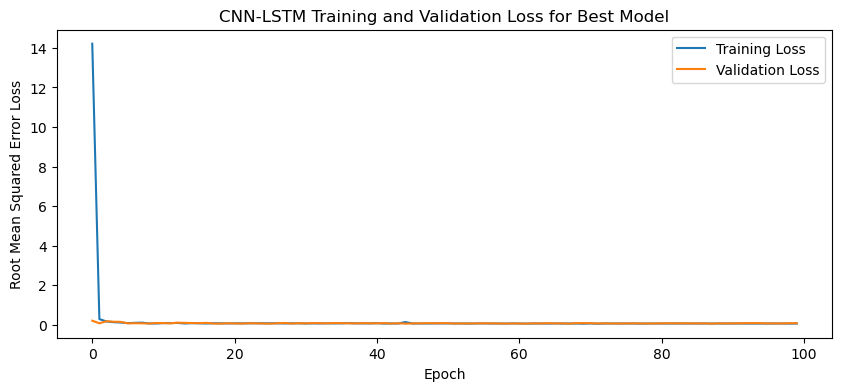

1/1 - 2s - loss: 0.0828 - 2s/epoch - 2s/step
Test Loss: 0.08276774734258652
Fold 2:
Epoch 1/100
19/19 [==============================] - 17s 440ms/step - loss: 18.1470 - val_loss: 0.6176
Epoch 2/100
19/19 [==============================] - 5s 264ms/step - loss: 0.3591 - val_loss: 0.3470
Epoch 3/100
19/19 [==============================] - 4s 218ms/step - loss: 0.1804 - val_loss: 0.2076
Epoch 4/100
19/19 [==============================] - 5s 272ms/step - loss: 0.2100 - val_loss: 0.3219
Epoch 5/100
19/19 [==============================] - 6s 294ms/step - loss: 0.1892 - val_loss: 0.2526
Epoch 6/100
19/19 [==============================] - 10s 515ms/step - loss: 0.1597 - val_loss: 0.1966
Epoch 7/100
19/19 [==============================] - 5s 282ms/step - loss: 0.1747 - val_loss: 0.2779
Epoch 8/100
19/19 [==============================] - 5s 267ms/step - loss: 0.1480 - val_loss: 0.1103
Epoch 9/100
19/19 [==============================] - 5s 238ms/step - loss: 0.1043 - val_loss: 0.1029
Epoc

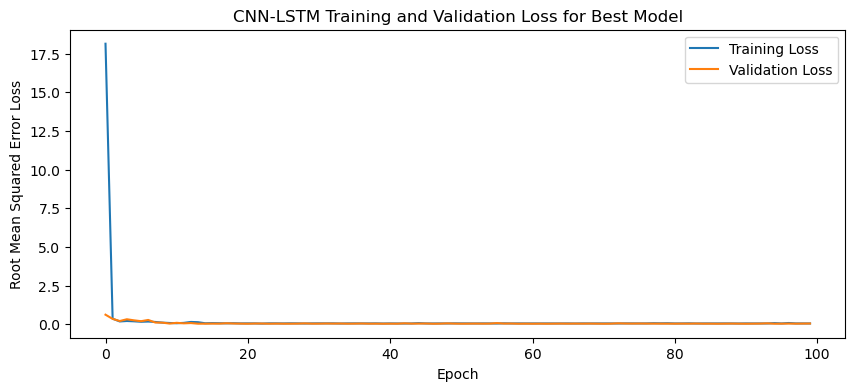

1/1 - 2s - loss: 0.1074 - 2s/epoch - 2s/step
Test Loss: 0.10739164054393768
Fold 3:
Epoch 1/100
19/19 [==============================] - 16s 433ms/step - loss: 10.4034 - val_loss: 0.7158
Epoch 2/100
19/19 [==============================] - 5s 274ms/step - loss: 0.3963 - val_loss: 0.1257
Epoch 3/100
19/19 [==============================] - 5s 248ms/step - loss: 0.2484 - val_loss: 0.2472
Epoch 4/100
19/19 [==============================] - 5s 256ms/step - loss: 0.2719 - val_loss: 0.0449
Epoch 5/100
19/19 [==============================] - 5s 289ms/step - loss: 0.1691 - val_loss: 0.1318
Epoch 6/100
19/19 [==============================] - 6s 311ms/step - loss: 0.1009 - val_loss: 0.0979
Epoch 7/100
19/19 [==============================] - 6s 323ms/step - loss: 0.1605 - val_loss: 0.0454
Epoch 8/100
19/19 [==============================] - 5s 260ms/step - loss: 0.0975 - val_loss: 0.0849
Epoch 9/100
19/19 [==============================] - 5s 273ms/step - loss: 0.1071 - val_loss: 0.1175
Epoch

In [ ]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit a CNN-LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

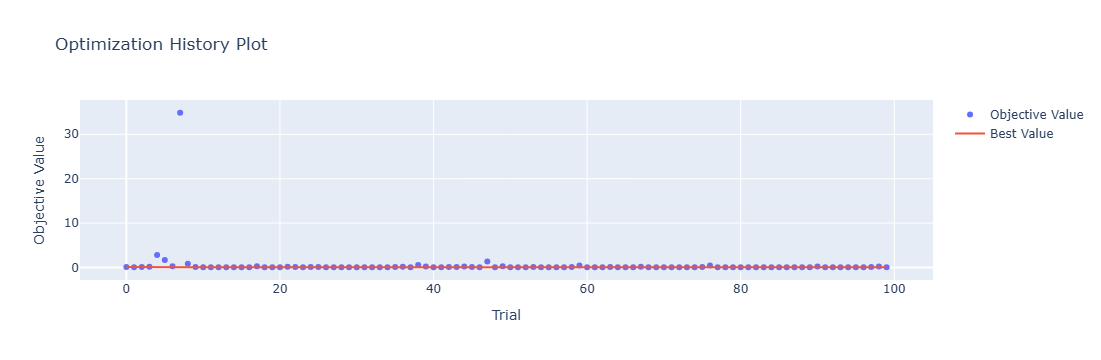

In [10]:
optuna.visualization.plot_optimization_history(study)

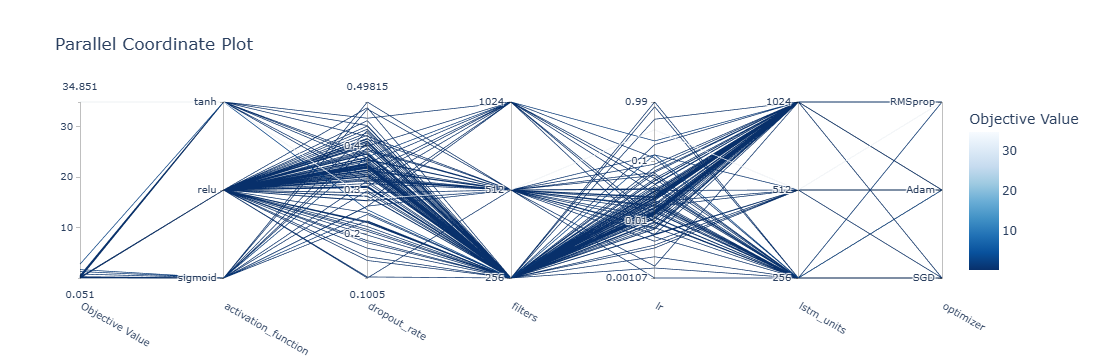

In [11]:
optuna.visualization.plot_parallel_coordinate(study)

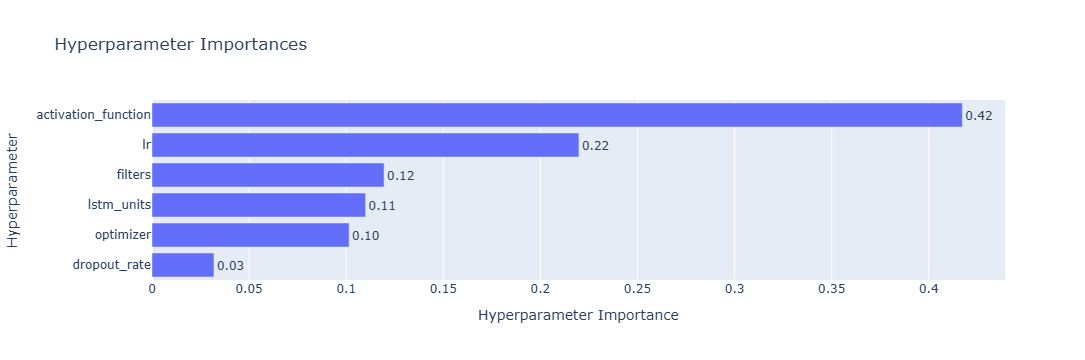

In [12]:
optuna.visualization.plot_param_importances(study)

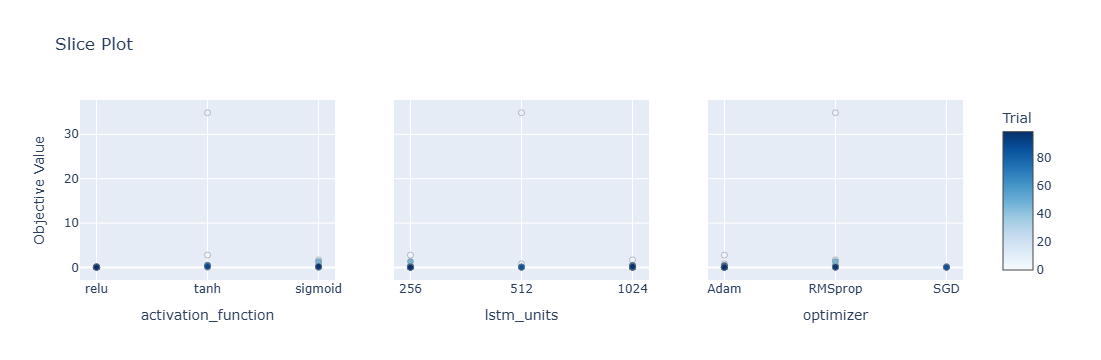

In [13]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

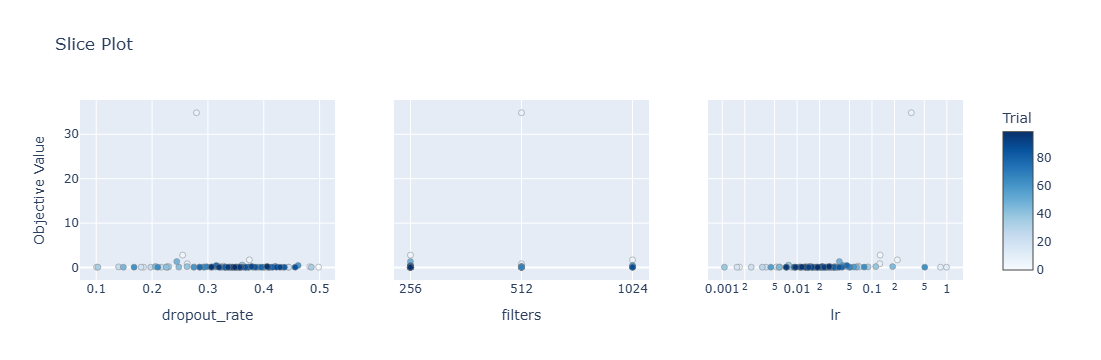

In [16]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate', 'filters'])

[[20.84 20.69 20.47 20.3  20.46 20.31 20.43 20.63 21.05 20.79 20.3  20.47
  19.79 21.11 21.38 20.92 20.47 21.77 22.5  22.86 21.64 21.57 21.74 21.57
  21.81 22.23 22.62]
 [16.57 15.99 15.39 15.45 15.98 15.45 15.57 15.59 15.96 16.16 15.83 15.88
  15.64 16.44 17.   15.83 15.63 16.9  17.06 17.3  17.26 18.21 17.38 16.87
  17.15 16.98 18.47]]
Epoch 1/100
19/19 [==============================] - 31s 491ms/step - loss: 16.7959 - accuracy: 0.0000e+00 - mae: 16.7959 - rmse: 16.7959 - mape: 2731.6931 - pearson: nan - val_loss: 0.4590 - val_accuracy: 0.0000e+00 - val_mae: 0.4590 - val_rmse: 0.4590 - val_mape: 77.7008 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 3s 148ms/step - loss: 0.3775 - accuracy: 0.0000e+00 - mae: 0.3775 - rmse: 0.3775 - mape: 67.4127 - pearson: nan - val_loss: 0.3732 - val_accuracy: 0.0000e+00 - val_mae: 0.3732 - val_rmse: 0.3732 - val_mape: 62.8453 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 3s 138ms/step - loss: 0.2802

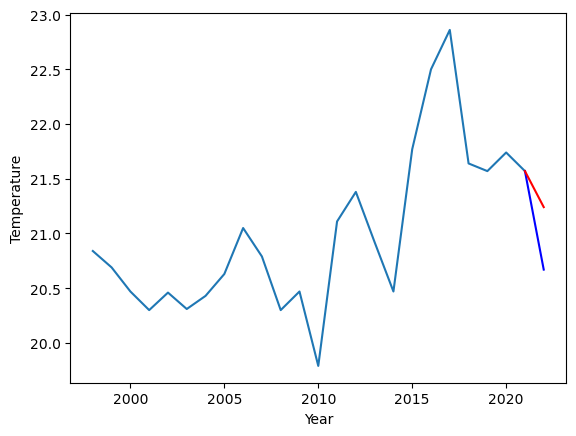

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
16.06		16.97		0.91


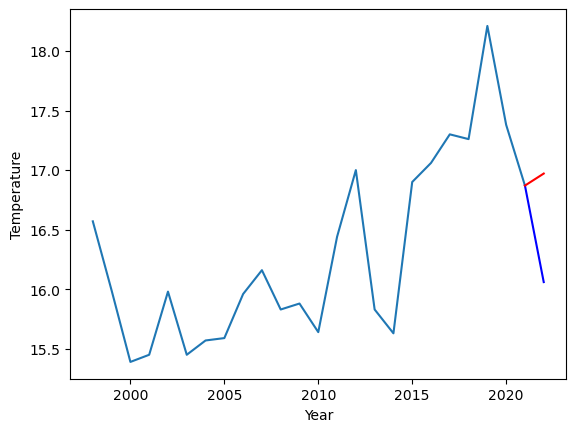

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   20.67  21.240971
1                1   16.06  16.970971


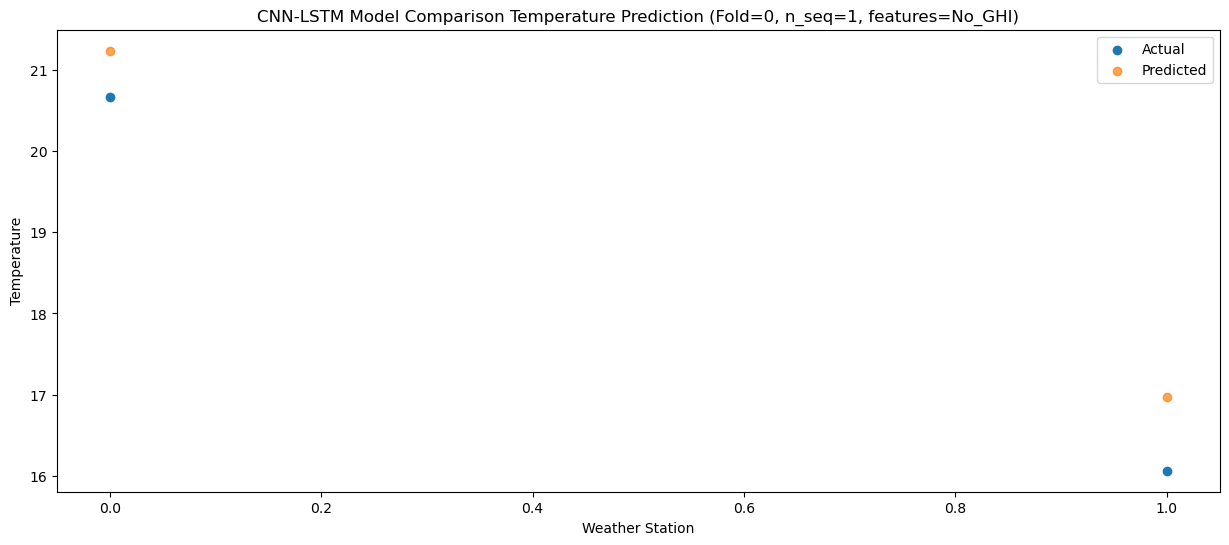

f, t:
[[20.67 16.06]]
[[21.24097076 16.97097076]]
Year at t+1:
t+1 SKRMSE: 0.760222
t+1 KRMSE: 0.760222
t+1 MAE: 0.740971
t+1 SKMAPE: 0.042173
t+1 R2_SCORE: 0.891222
t+1 KMAPE: 0.042173
t+1 PEARSON: 1.000000
Metrics for this Fold:
SKRMSE: 0.760222
KRMSE: 0.760222
MAE: 0.740971
SKMAPE: 0.042173
R2_SCORE: 0.891222
KMAPE: 0.042173
PEARSON: 1.000000
Model: "sequential_510"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_510 (Conv1D)         (None, 1, 256)            62208     
                                                                 
 max_pooling1d_510 (MaxPooli  (None, 1, 256)           0         
 ng1D)                                                           
                                                                 
 dropout_1530 (Dropout)      (None, 1, 256)            0         
                                                                 
 lstm_1020 (LSTM)            (None

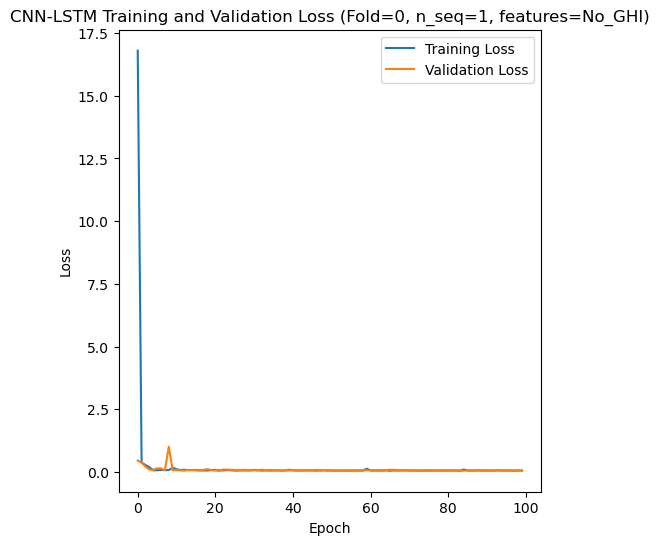

[[19.54 18.69 17.98 18.61 18.9  18.32 18.53 18.52 18.91 19.16 18.59 18.48
  18.2  19.26 19.25 18.86 18.95 19.48 19.77 19.73 19.56 19.64 19.73 18.81
  19.15 19.99 20.79]
 [19.69 19.59 19.68 19.6  19.14 19.33 18.41 19.15 20.48 18.58 19.32 19.44
  18.75 20.43 20.08 18.77 18.96 18.48 19.51 19.89 19.04 19.17 19.69 19.3
  19.3  20.61 21.9 ]]
Epoch 1/100
19/19 [==============================] - 29s 443ms/step - loss: 18.6281 - accuracy: 0.0000e+00 - mae: 18.6281 - rmse: 18.6281 - mape: 3270.9016 - pearson: nan - val_loss: 0.4420 - val_accuracy: 0.0000e+00 - val_mae: 0.4420 - val_rmse: 0.4420 - val_mape: 66.1761 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 3s 147ms/step - loss: 0.3318 - accuracy: 0.0000e+00 - mae: 0.3318 - rmse: 0.3318 - mape: 53.9503 - pearson: nan - val_loss: 0.9033 - val_accuracy: 0.0000e+00 - val_mae: 0.9033 - val_rmse: 0.9033 - val_mape: 136.3900 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 3s 140ms/step - loss: 0.3385

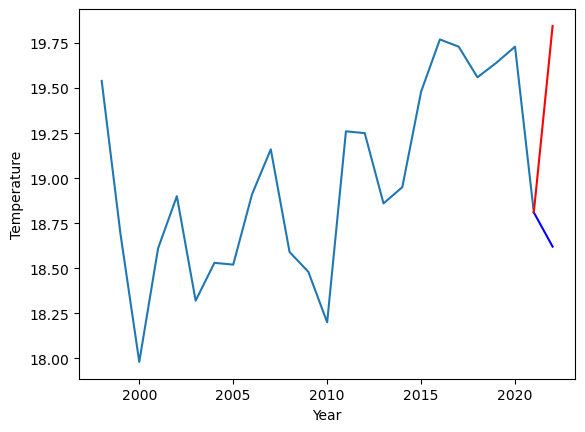

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
19.30		20.00		0.70


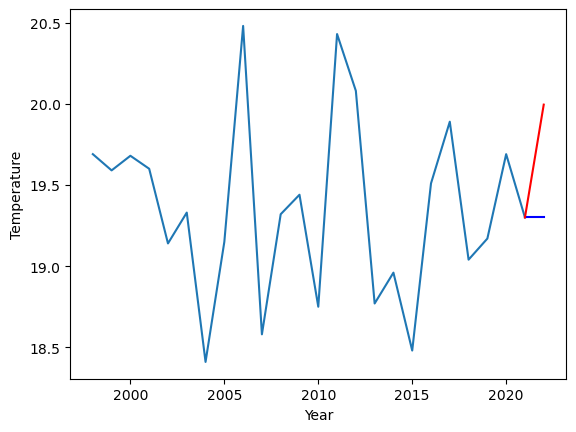

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   18.62  19.845137
1                1   19.30  19.995137


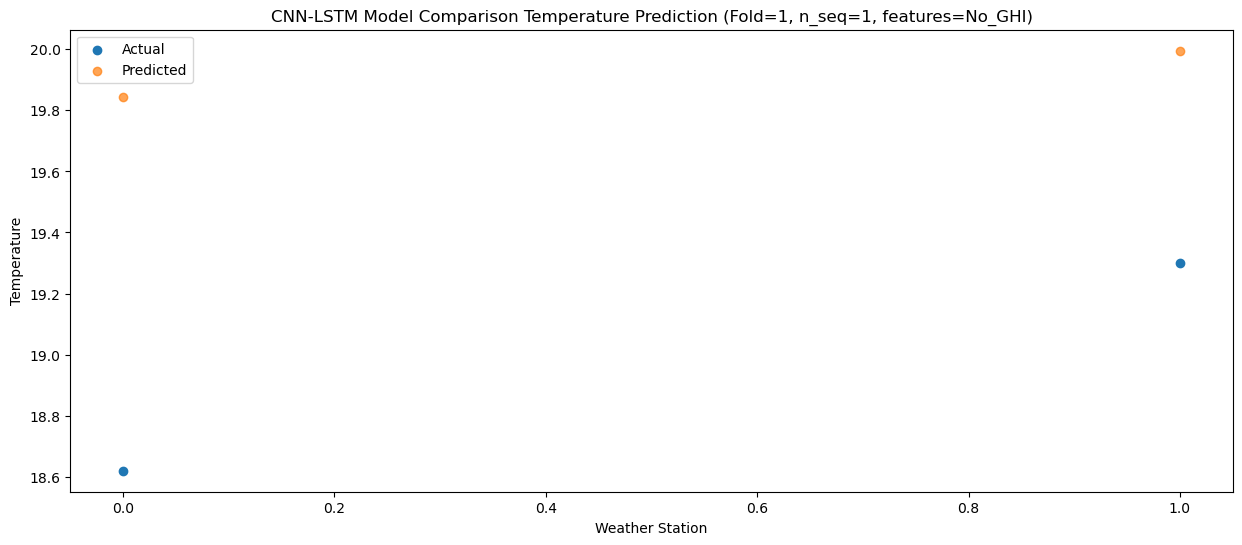

f, t:
[[18.62 19.3 ]]
[[19.84513662 19.99513662]]
Year at t+1:
t+1 SKRMSE: 0.996036
t+1 KRMSE: 0.996036
t+1 MAE: 0.960137
t+1 SKMAPE: 0.050907
t+1 R2_SCORE: -7.582070
t+1 KMAPE: 0.050907
t+1 PEARSON: 1.000000
Metrics for this Fold:
SKRMSE: 0.996036
KRMSE: 0.996036
MAE: 0.960137
SKMAPE: 0.050907
R2_SCORE: -7.582070
KMAPE: 0.050907
PEARSON: 1.000000
Model: "sequential_511"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_511 (Conv1D)         (None, 1, 256)            62208     
                                                                 
 max_pooling1d_511 (MaxPooli  (None, 1, 256)           0         
 ng1D)                                                           
                                                                 
 dropout_1533 (Dropout)      (None, 1, 256)            0         
                                                                 
 lstm_1022 (LSTM)            (No

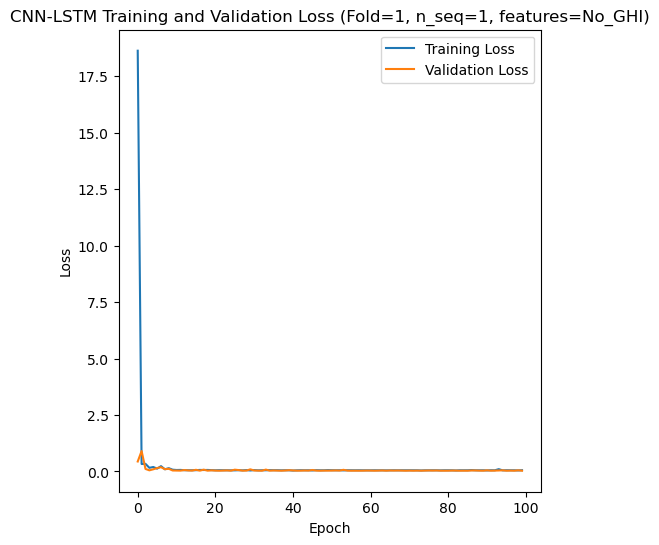

[[16.84 16.42 15.63 15.84 16.01 15.21 15.86 15.86 16.6  17.15 15.61 15.43
  15.69 16.61 16.97 15.29 15.43 16.62 17.18 16.96 16.33 17.09 16.39 16.63
  16.6  17.04 18.25]
 [13.51 12.74 11.83 12.67 12.83 11.71 12.25 12.85 13.05 13.49 12.15 12.07
  12.6  13.05 14.02 12.15 11.53 12.87 13.64 13.46 12.99 13.32 13.31 13.3
  12.84 13.63 15.32]]
Epoch 1/100
19/19 [==============================] - 10s 186ms/step - loss: 13.1043 - accuracy: 0.0000e+00 - mae: 13.1043 - rmse: 13.1043 - mape: 2241.1311 - pearson: nan - val_loss: 0.0464 - val_accuracy: 0.0000e+00 - val_mae: 0.0464 - val_rmse: 0.0464 - val_mape: 8.7574 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 2s 80ms/step - loss: 0.2713 - accuracy: 0.0000e+00 - mae: 0.2713 - rmse: 0.2713 - mape: 44.3937 - pearson: nan - val_loss: 0.0515 - val_accuracy: 0.0000e+00 - val_mae: 0.0515 - val_rmse: 0.0515 - val_mape: 9.1711 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 2s 86ms/step - loss: 0.1194 - ac

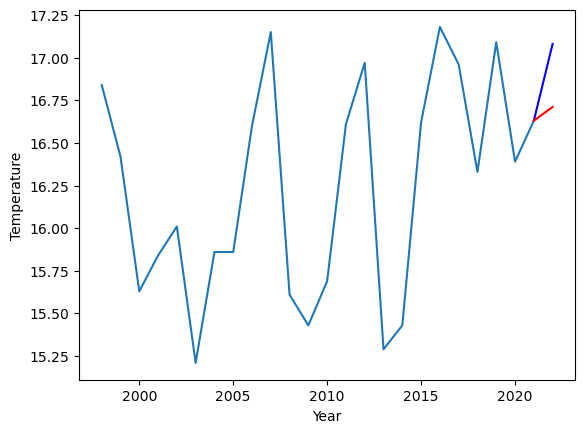

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.50		13.38		-0.12


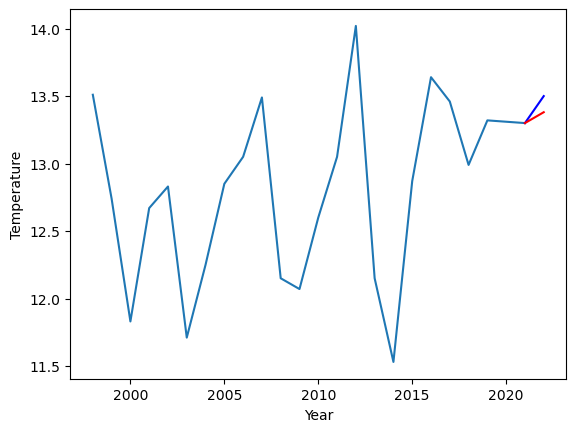

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   17.08  16.710582
1                1   13.50  13.380582


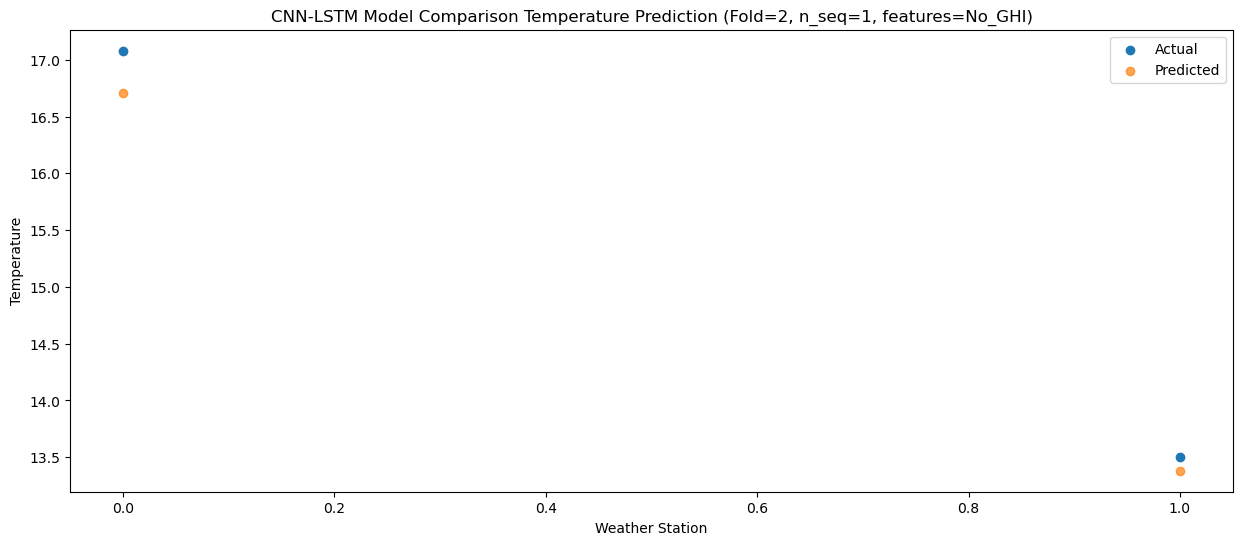

f, t:
[[17.08 13.5 ]]
[[16.71058243 13.38058243]]
Year at t+1:
t+1 SKRMSE: 0.274527
t+1 KRMSE: 0.274527
t+1 MAE: 0.244418
t+1 SKMAPE: 0.015237
t+1 R2_SCORE: 0.976479
t+1 KMAPE: 0.015237
t+1 PEARSON: 1.000000
Metrics for this Fold:
SKRMSE: 0.274527
KRMSE: 0.274527
MAE: 0.244418
SKMAPE: 0.015237
R2_SCORE: 0.976479
KMAPE: 0.015237
PEARSON: 1.000000
Model: "sequential_512"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_512 (Conv1D)         (None, 1, 256)            62208     
                                                                 
 max_pooling1d_512 (MaxPooli  (None, 1, 256)           0         
 ng1D)                                                           
                                                                 
 dropout_1536 (Dropout)      (None, 1, 256)            0         
                                                                 
 lstm_1024 (LSTM)            (None

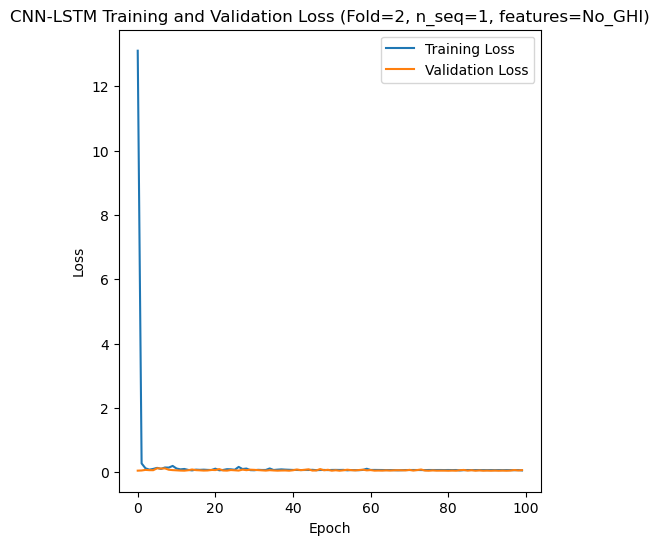

[[14.79 16.53 17.4  17.93 17.46 17.79 17.15 17.27 16.83 16.99 17.41 16.9
  16.66 16.28 17.66 17.63 19.01 18.49 18.19 18.12 18.2  17.83 17.88 18.2
  18.19 17.9  20.04]
 [14.06 13.64 12.62 13.34 13.58 12.56 13.34 13.7  13.71 13.89 12.74 12.51
  12.94 13.34 14.11 12.94 11.91 13.01 14.3  14.13 13.64 14.05 13.93 13.73
  13.43 14.45 16.49]]
Epoch 1/100
20/20 [==============================] - 14s 208ms/step - loss: 18.0398 - accuracy: 0.0000e+00 - mae: 18.0398 - rmse: 18.0398 - mape: 2657.3599 - pearson: nan - val_loss: 0.5479 - val_accuracy: 0.0000e+00 - val_mae: 0.5479 - val_rmse: 0.5479 - val_mape: 76.3331 - val_pearson: nan
Epoch 2/100
20/20 [==============================] - 2s 77ms/step - loss: 0.3559 - accuracy: 0.0000e+00 - mae: 0.3559 - rmse: 0.3559 - mape: 54.0962 - pearson: nan - val_loss: 0.4297 - val_accuracy: 0.0000e+00 - val_mae: 0.4297 - val_rmse: 0.4297 - val_mape: 59.8563 - val_pearson: nan
Epoch 3/100
20/20 [==============================] - 2s 78ms/step - loss: 0.1914 - a

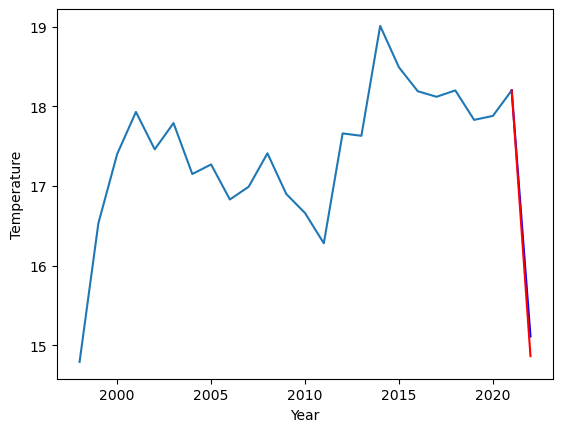

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.86		14.13		0.27


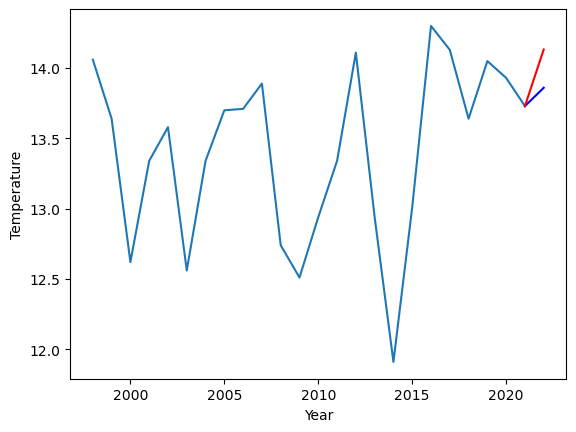

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   15.11  14.862301
1                1   13.86  14.132301


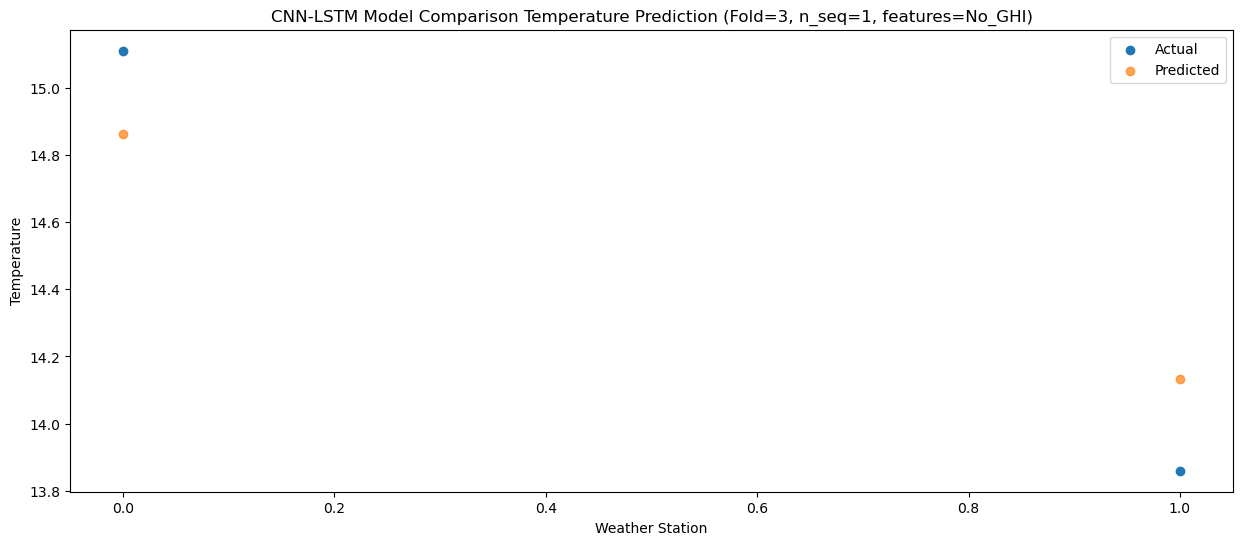

f, t:
[[15.11 13.86]]
[[14.86230059 14.13230059]]
Year at t+1:
t+1 SKRMSE: 0.260291
t+1 KRMSE: 0.260291
t+1 MAE: 0.260000
t+1 SKMAPE: 0.018020
t+1 R2_SCORE: 0.826557
t+1 KMAPE: 0.018020
t+1 PEARSON: 1.000000
Metrics for this Fold:
SKRMSE: 0.260291
KRMSE: 0.260291
MAE: 0.260000
SKMAPE: 0.018020
R2_SCORE: 0.826557
KMAPE: 0.018020
PEARSON: 1.000000
Model: "sequential_513"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_513 (Conv1D)         (None, 1, 256)            62208     
                                                                 
 max_pooling1d_513 (MaxPooli  (None, 1, 256)           0         
 ng1D)                                                           
                                                                 
 dropout_1539 (Dropout)      (None, 1, 256)            0         
                                                                 
 lstm_1026 (LSTM)            (None

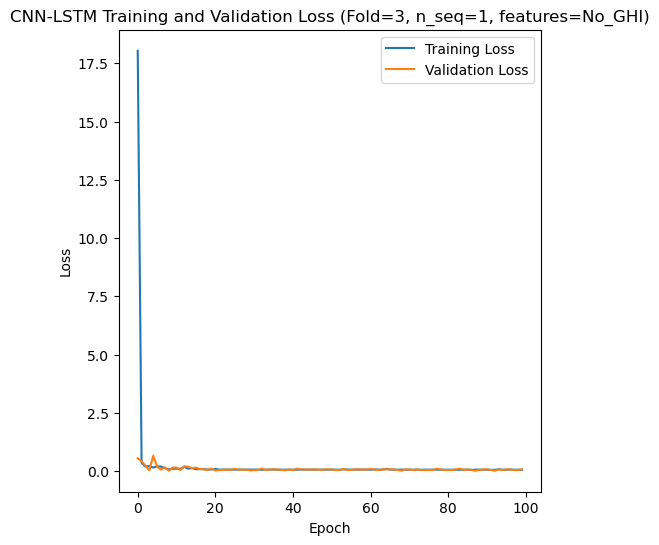

[[21.14 18.96 18.26 17.93 17.59 18.09 18.   18.94 19.77 18.17 18.51 17.84
  17.96 19.05 19.41 17.5  17.5  18.37 18.89 19.09 18.25 18.12 18.64 18.22
  18.72 19.65 20.58]
 [12.93 12.18 11.5  12.1  11.94 11.27 11.81 12.49 12.65 12.57 10.89 11.63
  12.44 12.56 14.1  11.08 10.78 12.73 13.75 13.68 12.38 11.68 12.24 12.56
  11.69 13.17 14.51]]
Epoch 1/100
19/19 [==============================] - 37s 507ms/step - loss: 17.6740 - accuracy: 0.0000e+00 - mae: 17.6740 - rmse: 17.6740 - mape: 2674.6638 - pearson: nan - val_loss: 0.6164 - val_accuracy: 0.0000e+00 - val_mae: 0.6164 - val_rmse: 0.6164 - val_mape: 94.0150 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 2s 121ms/step - loss: 0.2882 - accuracy: 0.0000e+00 - mae: 0.2882 - rmse: 0.2882 - mape: 47.2905 - pearson: nan - val_loss: 0.0542 - val_accuracy: 0.0000e+00 - val_mae: 0.0542 - val_rmse: 0.0542 - val_mape: 7.9874 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 2s 131ms/step - loss: 0.2281 

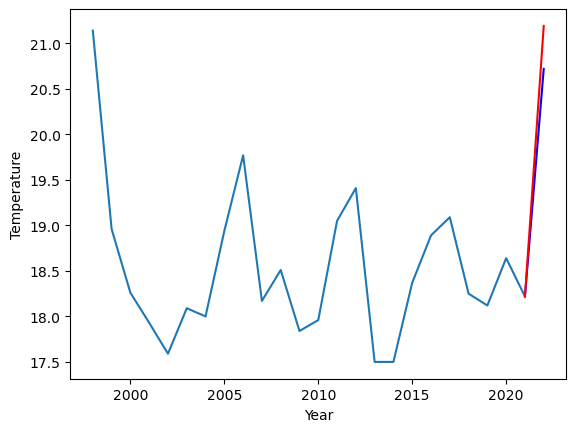

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.25		12.98		-0.27


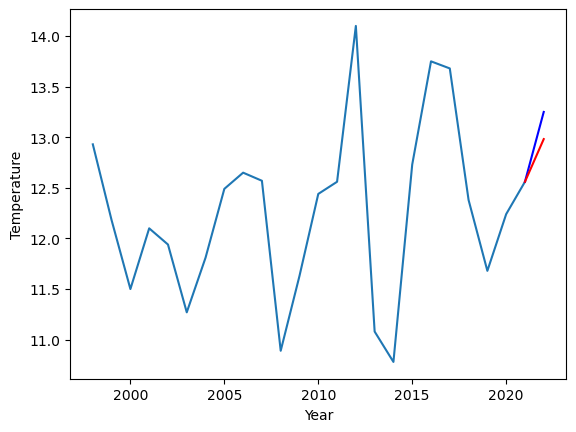

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   20.72  21.191887
1                1   13.25  12.981887


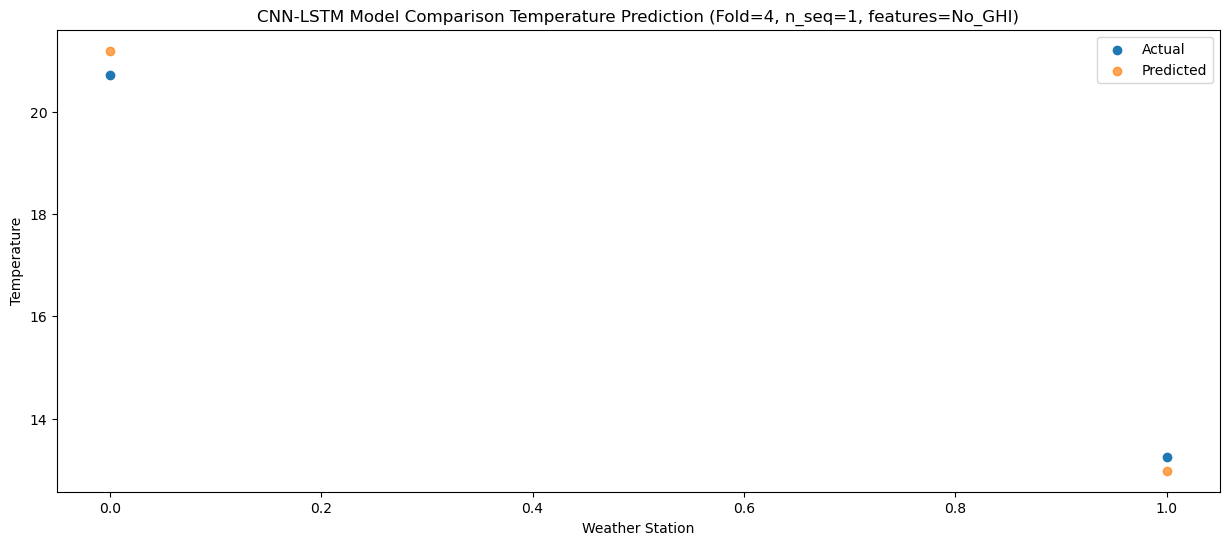

f, t:
[[20.72 13.25]]
[[21.19188747 12.98188747]]
Year at t+1:
t+1 SKRMSE: 0.383772
t+1 KRMSE: 0.383772
t+1 MAE: 0.370000
t+1 SKMAPE: 0.021505
t+1 R2_SCORE: 0.989442
t+1 KMAPE: 0.021505
t+1 PEARSON: 1.000000
Metrics for this Fold:
SKRMSE: 0.383772
KRMSE: 0.383772
MAE: 0.370000
SKMAPE: 0.021505
R2_SCORE: 0.989442
KMAPE: 0.021505
PEARSON: 1.000000
Model: "sequential_514"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_514 (Conv1D)         (None, 1, 256)            62208     
                                                                 
 max_pooling1d_514 (MaxPooli  (None, 1, 256)           0         
 ng1D)                                                           
                                                                 
 dropout_1542 (Dropout)      (None, 1, 256)            0         
                                                                 
 lstm_1028 (LSTM)            (None

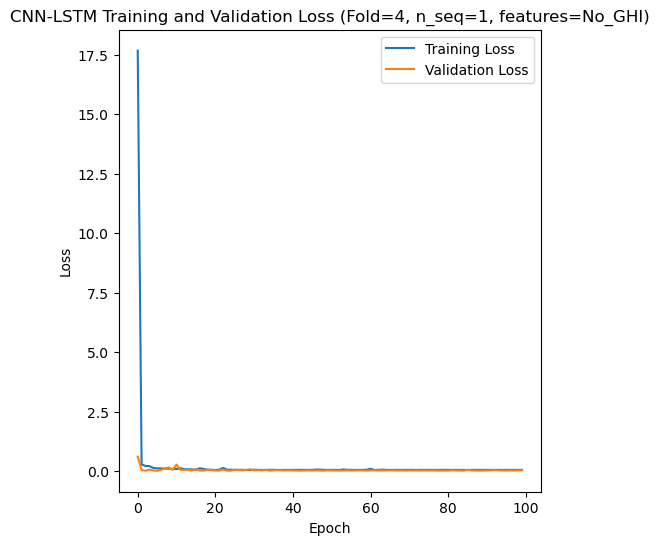

[[0.7602221140827273], [0.996035808082317], [0.27452677057923924], [0.2602908076142669], [0.383772142752088]]
[[array(0.76022211)], [array(0.99603581)], [array(0.27452677)], [array(0.26029081)], [array(0.38377214)]]
[[0.740970757007597], [0.9601366209983837], [0.244417568445205], [0.2599999999999998], [0.370000000000001]]
[[0.04217306156715328], [0.05090712625604358], [0.015237204534335963], [0.01801979265620758], [0.021504699792548793]]
[[0.8912224838504597], [-7.582070337216129], [0.976478590629298], [0.826556660407072], [0.9894423883806512]]
[[array(0.04217306)], [array(0.05090713)], [array(0.0152372)], [array(0.01801979)], [array(0.0215047)]]
[[array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)]]
[20.67 16.06 18.62 19.3  17.08 13.5  15.11 13.86 20.72 13.25]
[21.24097076 16.97097076 19.84513662 19.99513662 16.71058243 13.38058243
 14.86230059 14.13230059 21.19188747 12.98188747]
Accuracy Results:
RMSE for each fold:
[[0.7602221140827273], [0.996035808082317], [0.274526770

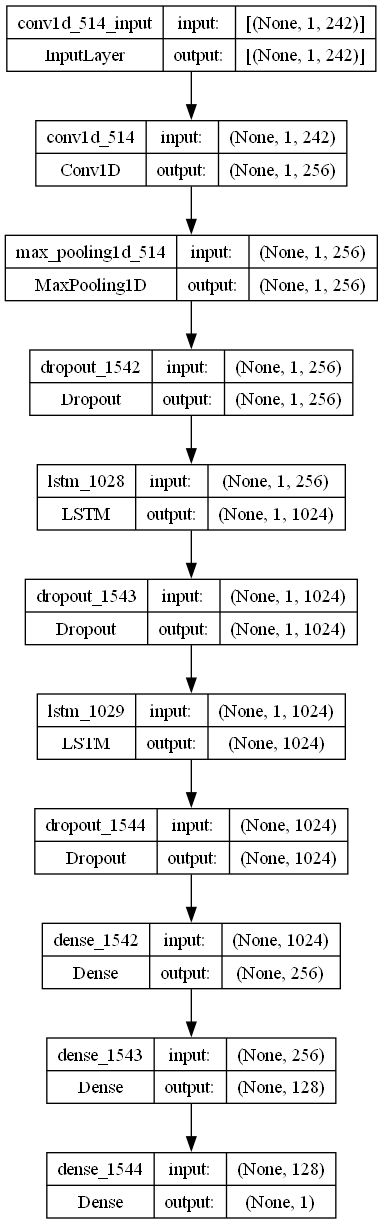

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best CNN-LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 256
    lr = 0.013560643010393014 
    optimizer = RMSprop(learning_rate = lr)
    activation_function = 'relu'
    lstm_units = 1024
    dropout_rate = 0.2254480234008693

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with a CNN-LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='CNN-LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)                        
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'CNN-LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "cnnlstm_model_optimized_CV_S1_No_GHI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)